In [149]:
# PROBLEM 1
import numpy as np
from keras.datasets import reuters
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

In [150]:
# Load the Reuters dataset
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [151]:
# Vectorize the data per example
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [152]:
# One-hot encode the labels per example
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [153]:
# Split the training data into training and validation sets per instruction
partial_x_train = x_train[:6982]
x_val = x_train[6982:8982]
partial_y_train = one_hot_train_labels[:6982]
y_val = one_hot_train_labels[6982:8982]

In [154]:
# Properly define the model

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [155]:
# Fit model and record history
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=0)

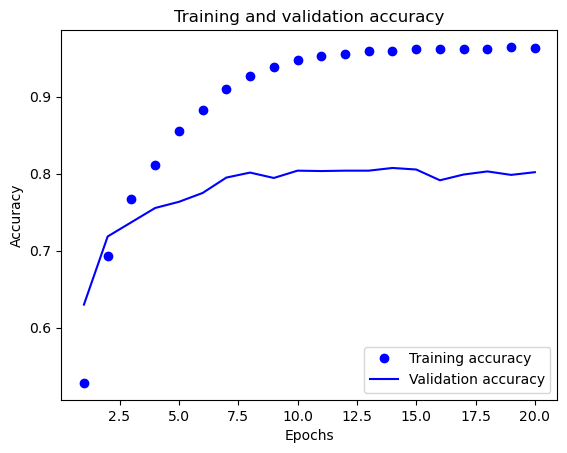

In [156]:
# Plot the training and validation accuracy
history_dict = history.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [157]:
# From chart we start to see overfitting at around 10 epochs
optimal_epochs = 10

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=optimal_epochs,
          batch_size=512,
          validation_data=(x_val, y_val),
          verbose=0)

In [158]:
# Evaluate the model on the test data
results = model.evaluate(x_test, one_hot_test_labels)
results

71/71 [==============================] - 0s 465us/step - loss: 0.9599 - accuracy: 0.7974


[0.9599230289459229, 0.7974176406860352]

In [159]:
# PROBLEM 2

In [160]:
from keras import regularizers

# Define function to create model with L2 regularization, specifying lambda
def create_model(l2_lambda):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(10000,)))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dense(46, activation='softmax'))
    
    model.compile(optimizer=optimizers.RMSprop(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [161]:
# Test 10 different lambdas
l2_lambdas = [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
optimal_epoch = []
val_accuracies = []

# Loop through test lambdas and create models
for l2_lambda in l2_lambdas:
    model = create_model(l2_lambda)
    history = model.fit(partial_x_train,partial_y_train,
                        epochs=20,
                        batch_size=512,
                        validation_split=0.2,
                        verbose=0)
    
    # Get the epoch with the highest validation accuracy
    val_acc = history.history['val_accuracy']
    best_epoch = np.argmax(val_acc)
    optimal_epoch.append(best_epoch)
    val_accuracies.append(val_acc[best_epoch])

    print(f"Lambda: {l2_lambda} - Best Epoch: {best_epoch+1} - Best Val Accuracy: {val_acc[best_epoch]:.4f}")


Lambda: 1e-09 - Best Epoch: 9 - Best Val Accuracy: 0.8031
Lambda: 1e-08 - Best Epoch: 10 - Best Val Accuracy: 0.8031
Lambda: 1e-07 - Best Epoch: 10 - Best Val Accuracy: 0.7989
Lambda: 1e-06 - Best Epoch: 17 - Best Val Accuracy: 0.8089
Lambda: 1e-05 - Best Epoch: 18 - Best Val Accuracy: 0.8103
Lambda: 0.0001 - Best Epoch: 19 - Best Val Accuracy: 0.8003
Lambda: 0.001 - Best Epoch: 18 - Best Val Accuracy: 0.8103
Lambda: 0.01 - Best Epoch: 17 - Best Val Accuracy: 0.7681
Lambda: 0.1 - Best Epoch: 19 - Best Val Accuracy: 0.5719
Lambda: 1 - Best Epoch: 2 - Best Val Accuracy: 0.5204


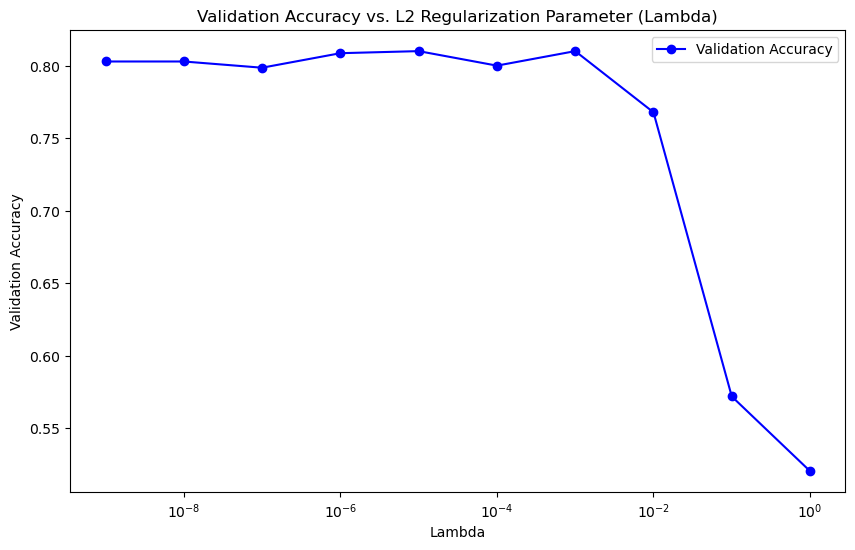

In [162]:
# Plot results from above
plt.figure(figsize=(10, 6))
plt.plot(l2_lambdas, val_accuracies, 'bo-', label='Validation Accuracy')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. L2 Regularization Parameter (Lambda)')
plt.legend()
plt.show()

In [163]:
# Get optimal lambda value and respective validation accuracy
optimal_lambda_index = np.argmax(val_accuracies)
optimal_lambda = l2_lambdas[optimal_lambda_index]
optimal_val_accuracy = val_accuracies[optimal_lambda_index]

print(f"Optimal Lambda: {optimal_lambda}")
print(f"Optimal Validation Accuracy: {optimal_val_accuracy:.4f}")

Optimal Lambda: 1e-05
Optimal Validation Accuracy: 0.8103


In [164]:
# PROBLEM 3

In [165]:
# Define function to create model with Dropout regularization
def create_model_with_dropout(dropout_rate, max_features, max_len):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(46, activation='softmax'))
    
    model.compile(optimizer=optimizers.RMSprop(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [166]:
# Test 10 different dropout rates
dropout_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
optimal_epoch = []
val_accuracies = []

for dropout_rate in dropout_rates:
    model = create_model_with_dropout(dropout_rate, max_features, max_len)
    history = model.fit(partial_x_train,partial_y_train,
                        epochs=20,
                        batch_size=512,
                        validation_split=0.2,
                        verbose=0)
    
    # Get the epoch with the highest validation accuracy
    val_acc = history.history['val_accuracy']
    best_epoch = np.argmax(val_acc)
    optimal_epoch.append(best_epoch)
    val_accuracies.append(val_acc[best_epoch])
    
    print(f"Dropout Rate: {dropout_rate} - Best Epoch: {best_epoch+1} - Best Val Accuracy: {val_acc[best_epoch]:.4f}")


Dropout Rate: 0.001 - Best Epoch: 14 - Best Val Accuracy: 0.8039
Dropout Rate: 0.005 - Best Epoch: 11 - Best Val Accuracy: 0.8060
Dropout Rate: 0.01 - Best Epoch: 13 - Best Val Accuracy: 0.7996
Dropout Rate: 0.05 - Best Epoch: 20 - Best Val Accuracy: 0.8046
Dropout Rate: 0.1 - Best Epoch: 12 - Best Val Accuracy: 0.8046
Dropout Rate: 0.2 - Best Epoch: 17 - Best Val Accuracy: 0.8103
Dropout Rate: 0.3 - Best Epoch: 18 - Best Val Accuracy: 0.8017
Dropout Rate: 0.4 - Best Epoch: 17 - Best Val Accuracy: 0.7853
Dropout Rate: 0.5 - Best Epoch: 20 - Best Val Accuracy: 0.7838
Dropout Rate: 0.6 - Best Epoch: 19 - Best Val Accuracy: 0.7581


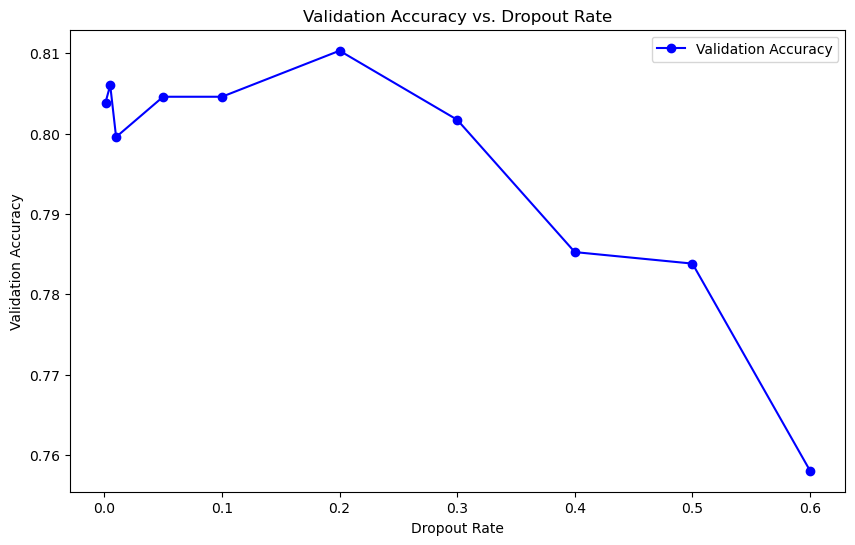

In [167]:
# Plot results from above
plt.figure(figsize=(10, 6))
plt.plot(dropout_rates, val_accuracies, 'bo-', label='Validation Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Dropout Rate')
plt.legend()
plt.show()

In [168]:
# Get optimal dropout rate value and respective validation accuracy
optimal_dropout_index = np.argmax(val_accuracies)
optimal_dropout_rate = dropout_rates[optimal_dropout_index]
optimal_val_accuracy = val_accuracies[optimal_dropout_index]

print(f"Optimal Dropout Rate: {optimal_dropout_rate}")
print(f"Optimal Validation Accuracy: {optimal_val_accuracy:.4f}")

Optimal Dropout Rate: 0.2
Optimal Validation Accuracy: 0.8103
